### Importações necessárias

In [93]:
import numpy as np
import math
from numpy import *
from numpy.linalg import inv
import numpy.linalg as la
import csv

# Parêmtros de entrada

In [94]:
str_nome = "led7"
str_nome_base = "led7_data_without_class.dat"
str_nome_regras = "led7_regras.txt"

 # Cálculo Dual Scaling

#### Ler arquivo base e criar Matriz padrão respota

In [95]:
arq = open(str_nome_base, 'r')
texto = arq.readlines()
base = []
item = set()
for linha in texto:
    valores_linha = []
    for value in linha.split():
        valores_linha.append(int(value))
        item.add(int(value))
    base.append(valores_linha)   
arq.close()

#print(valores)

F = np.zeros(shape=(len(base), len(item)))
for i in range(len(base)):
    for value in base[i]:
        F[i,value-1] = 1

#print(F)

#### Número de Dimensões do Espaço-solução (ns)

In [96]:
q = len(base[0]) #número de questões (categorias)
m = F.shape[1] #número de itens
n = F.shape[0] #número de transações

ns = m - q - 1

print('Total de Dimensões: ', ns,'.')

Total de Dimensões:  6 .


#### Matriz Diagonal de Linhas (Dr) 

In [97]:
#Cálculo da Matriz Diagonal de Linhas de F
fr = np.sum(F, axis=1)
Dr = np.diagflat(fr)

#print(fr)

#Cálculo da Matriz Diagonal de Colunas de F
fc = np.sum(F, axis=0)
Dc = np.diagflat(fc)
#print(fc)

#### Matriz Resultante (M)

In [98]:
Ft = np.transpose(F) #Matriz Transporta de F
Dri = np.linalg.inv(Dr) #Matriz Invertida de Dr
Dci = np.linalg.inv(Dc) #Matriz Invertida de Dc

#Cálculo da Matriz M
M = np.dot(np.dot(np.dot(Ft,Dri),F), Dci)
print(M)

[[0.14285714 0.         0.04545455 0.03065671 0.02366763 0.04168936
  0.04849039 0.03098515 0.0509983  0.01783077 0.02256989 0.03999784
  0.07452855 0.01712375]
 [0.         0.14285714 0.0974026  0.11220044 0.11918951 0.10116779
  0.09436675 0.11187199 0.09185885 0.12502638 0.12028725 0.1028593
  0.0683286  0.12573339]
 [0.07487923 0.0560106  0.14285714 0.         0.03320279 0.07073274
  0.08142726 0.05024069 0.07150596 0.0464233  0.0941267  0.05388898
  0.08499096 0.04816482]
 [0.06797792 0.08684654 0.         0.14285714 0.10965435 0.0721244
  0.06142988 0.09261645 0.07135118 0.09643385 0.04873044 0.08896816
  0.05786618 0.09469232]
 [0.02398206 0.04215852 0.02042313 0.05010893 0.14285714 0.
  0.02143511 0.04576581 0.03412784 0.04199198 0.02616055 0.03983568
  0.02208732 0.04557238]
 [0.11887509 0.10069863 0.12243402 0.09274821 0.         0.14285714
  0.12142204 0.09709133 0.1087293  0.10086516 0.11669659 0.10302146
  0.12076983 0.09728476]
 [0.06400966 0.0434835  0.06524927 0.0365701

#### Autovalores (AD) e Autovetores (AV) de M

In [99]:
#Array de Autovalores (uAD) e Autovetores (uAV) de M.
uAD, uAV = np.linalg.eig(M)

#Ordenando os Autovalores
AD = np.flip(np.sort(uAD, axis=0),0)

#np.savetxt('AV_python.txt',uAV.astype(np.float32))

#Ordenando os Autovetores em função dos Autovalores
uAVt = uAV.T.tolist()
AV=[]
for r in AD:
    #print(n)
    ix = uAD.tolist().index(r)
    AV.append(uAVt[ix])

#convertendo o resultado de um tipo complexo para Float32    
AD = AD.astype(np.float32)
AV = np.array(AV).T.astype(np.float32)

#removendo a primeira dimensão
AD = np.delete(AD,0,0)
AV = np.delete(AV,0,1)

#removendo as demais dimensões que devem ser desconsideradas (de forma que fiquem com dimensão ns)
count = ns
while count < AD.shape[0]:
    AD = np.delete(AD,count,0)
    AV = np.delete(AV,count,1)

#print(AD)
#print(AV)

C:\Users\altobelli\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\altobelli\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


#### rho

In [100]:
# Cálculo da Matriz unidimensional rho
rho = []

for i in range(ns):
    rho.append(math.sqrt(AD.tolist()[i]))

rho = np.array(rho)
#print(rho)   

#### Matriz Produto de Hadamard (H)

In [101]:
#Calculo da produto de Hadamard de Autovetores * autovetores
H = np.multiply(AV,AV)
#print(H.astype(np.float32))

#### Matriz T

In [102]:
#Matriz resultante T
T = np.dot(Dc, H)

#print(T.astype(np.float32))

#### Matriz Cc

In [103]:
sumCols = np.sum(T, axis=0).tolist()
#print (sumCols)
ft = np.sum(F)
# print(ft)
# print(sumCols)
Cc = []
for i in range(ns):
    r = math.sqrt(ft/float(sumCols[i]))
    Cc.append(r)

# print (Cc) 

#### Peso padrão dos Itens (x-normed)

In [104]:
#multiplicação da matriz de autovetores pela matrix Cc
x_normed = []
for r in AV:
    x_normed.append(np.multiply(r,Cc))

#print (np.array(x_normed))

#### Peso projetado dos Itens (x-projected)

In [105]:
#Resultado Principal do Dual Scaling
x_projected = []
for r in x_normed:
    x_projected.append(np.multiply(r,rho))

x_projected = np.array(x_projected)
print (x_projected.shape)

(14, 6)


#### Calculando Delta (d)

In [106]:
d = []
s = 100/np.sum(AD)
for r in AD:
    d.append(s*r)
print(d)

[32.044020251493954, 20.497351641469756, 14.702432453643716, 12.324312203591262, 11.94443492341623, 8.487453331389975]


# Calculo de Distância

## Distância entre itens (matriz de distância)

In [107]:
# não precisa calcular
DM = np.ndarray(shape=(x_projected.shape[0],x_projected.shape[0]), dtype=float)
for i in range(x_projected.shape[0]):
    for j in range(x_projected.shape[0]):
        quad_dist = 0
        for aux in range(ns):
            dist = (x_projected.item((i, aux)) / math.sqrt(fc.item(i)/n)) - (x_projected.item((j, aux)) / math.sqrt(fc.item(j)/n))
            quad_dist += (dist * dist)*rho.item(aux)
        DM.itemset((i,j),quad_dist)
        DM.itemset((j,i),quad_dist)

# print(DM)

## Função ponto médio

In [108]:
def ponto_medio(ids_item, x_projected, ns):
    ptm = np.zeros(ns)
    for item in ids_item:
        for i in range(x_projected.shape[1]):
            ptm[i] = ptm[i] + x_projected[item-1][i]
    ptm = ptm / float(len(ids_item))
    return ptm

## Função de cálculo de distância de antecedente e consequente

In [109]:
def distancia_antecedente_consequente(ptmA, supS, ptmC, supC, rho):
    quad_dist = 0
    for aux in range(ns):
        dist = ( ptmA[aux] / math.sqrt(supS) ) - (ptmC[aux] / math.sqrt(supC))
        quad_dist += (dist * dist)*rho[aux]
    return quad_dist    

## Função de cálculo de distância do ponto até a origem

In [110]:
def distancia_ponto_origem(pt, sup, rho):
    quad_dist = 0
    for aux in range(ns):
        dist = pt[aux] / math.sqrt(sup)
        quad_dist += (dist * dist)*rho[aux]
    return quad_dist

# Métricas de Interesse

## confiança P(B | A) = AUB / A

In [111]:
def get_confianca(sup, supA):
    return sup/supA

## lift P(AB)/P(A)P(B)

In [112]:
def get_lift(sup, supA, supB):
    return sup/supA*supB

## all-confidence 

In [113]:
def get_allconfidence(sup, ant, conseq, fc, n):
    maiorsuporte = 0
    for item in ant:
        if maiorsuporte < fc[item-1]:
            maiorsuporte = fc[item-1]
    for item in conseq:
        if maiorsuporte < fc[item-1]:
            maiorsuporte = fc[item-1]
    
    maiorsuporte = maiorsuporte/n
    
    return sup/maiorsuporte

# Preparando metadado

In [114]:
arq_regras = open(str_nome_regras, 'r')
arq_metadado = open(str_nome + ".csv", 'w', encoding='utf-8', newline='')

escreve_csv = csv.writer(arq_metadado, delimiter=';')
escreve_csv.writerow(['Antecedente', 'Consequente', 'Dist. Anteced. x Origem', 'Dist. Conseq. x Origem',
                      'Dist. Anteced. -> Conseq.', "Dist. Anteced. - Conseq.", "Suporte Ant.", "Suporte Cons.",
                      "Suporte", "Confianca", "Lift", "all-confianca"])

for linha_regra in arq_regras:
    info = linha_regra.split()
    antecedente = [int(i) for i in info[0].split(",")]
    consequente = [int(i) for i in info[1].split(",")]
    
    #métricas
    suporte = float(info[2])
    suporteA = float(info[4])
    suporteC = float(info[5])
    confianca = get_confianca(suporte,suporteA)
    lift = get_lift(suporte,suporteA,suporteC)
    allconfianca = get_allconfidence(suporte, antecedente, consequente, fc, n)

    # distâncias
    ptmA = ponto_medio(antecedente, x_projected, ns)
    ptmC = ponto_medio(consequente, x_projected, ns)
    
    dist_ant_orig = distancia_ponto_origem(ptmA, suporteA, rho)
    dist_conseq_orig = distancia_ponto_origem(ptmC, suporteA, rho)
    dist_ant_conseq = distancia_antecedente_consequente(ptmA, suporteA, ptmC, suporteC, rho)
    dist_ant_menos_conseq = dist_ant_orig - dist_conseq_orig
    
    #escreve arquivo csv
    b = [antecedente, consequente, dist_ant_orig, dist_conseq_orig, dist_ant_conseq, dist_ant_menos_conseq, 
         suporteA, suporteC, suporte, confianca, lift, allconfianca]
    escreve_csv.writerow(b)
    
arq_regras.close()
arq_metadado.close()

# Plots regras de associação

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

df = pd.read_csv(str_nome+".csv",sep=";")
display(df)

,Antecedente,Consequente,Dist. Anteced. x Origem,Dist. Conseq. x Origem,Dist. Anteced. -> Conseq.,Dist. Anteced. - Conseq.,Suporte Ant.,Suporte Cons.,Suporte,Confianca,Lift,all-confianca
0,"[3, 5]",[1],2.226186,5.883656,3.555779,-3.657470,0.060937,0.258750,0.017188,0.282062,0.072983,0.040324
1,"[1, 5]",[3],3.406143,11.283596,5.168556,-7.877454,0.043437,0.426250,0.017188,0.395700,0.168667,0.040324
2,"[1, 3]",[5],1.848792,2.754036,4.496417,-0.905244,0.135625,0.262188,0.017188,0.126732,0.033228,0.040324
3,"[3, 6]",[1],0.810714,0.981441,1.717324,-0.170727,0.365312,0.258750,0.118438,0.324211,0.083889,0.160526
4,"[1, 6]",[3],1.012817,2.276350,1.378169,-1.263534,0.215312,0.426250,0.118438,0.550076,0.234470,0.160526
5,"[1, 3]",[6],1.848792,2.754036,1.625977,-0.905244,0.135625,0.737812,0.118438,0.873276,0.644313,0.160526
6,"[3, 7]",[1],1.533906,1.841574,2.248820,-0.307668,0.194688,0.258750,0.094375,0.484750,0.125429,0.221408
7,"[1, 7]",[3],1.966083,4.227516,2.098737,-2.261433,0.115937,0.426250,0.094375,0.814020,0.346976,0.221408
8,"[1, 3]",[7],1.848792,2.996994,2.005724,-1.148203,0.135625,0.341562,0.094375,0.695853,0.237677,0.221408
9,"[3, 8]",[1],0.646318,1.548314,2.016540,-0.901997,0.231563,0.258750,0.041250,0.178137,0.046093,0.062648


## confiança

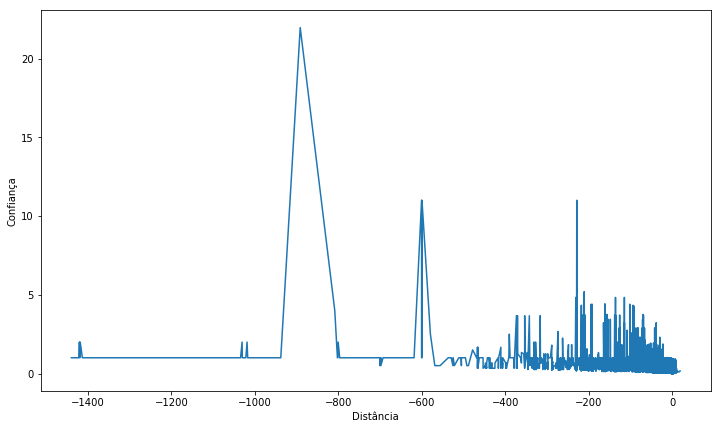

In [116]:
order = df.sort_values(by='Dist. Anteced. - Conseq.', ascending=False)
x = order['Dist. Anteced. - Conseq.'].tolist()
y = order['Confianca'].tolist()

width = 12
height = 7
plt.figure(figsize=(width, height))

plt.plot(x, y)
plt.ylabel('Confiança')
plt.xlabel('Distância')
plt.show()


## all-confiança

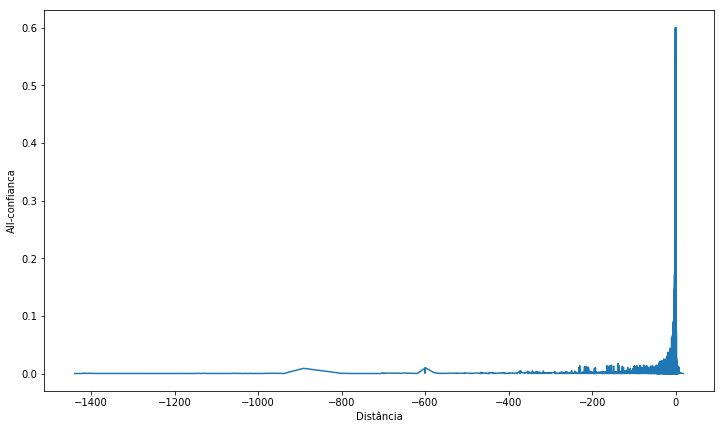

In [117]:
order = df.sort_values(by='Dist. Anteced. - Conseq.', ascending=False)
x = order['Dist. Anteced. - Conseq.'].tolist()
y = order['all-confianca'].tolist()

width = 12
height = 7
plt.figure(figsize=(width, height))

plt.plot(x, y)
plt.ylabel('All-confianca')
plt.xlabel('Distância')
plt.show()

## lift 

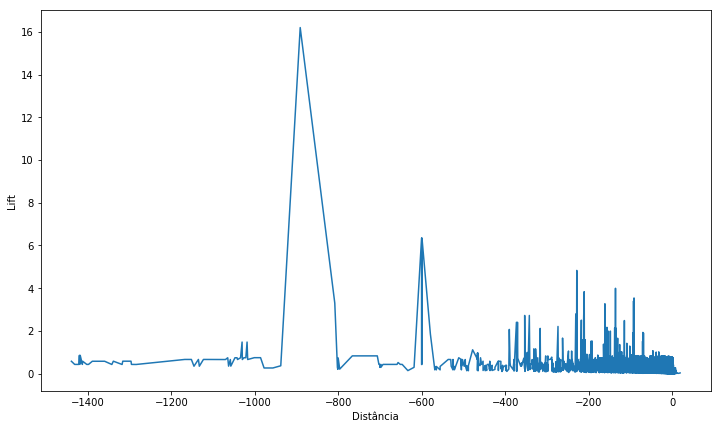

In [118]:
order = df.sort_values(by='Dist. Anteced. - Conseq.', ascending=False)
x = order['Dist. Anteced. - Conseq.'].tolist()
y = order['Lift'].tolist()

width = 12
height = 7
plt.figure(figsize=(width, height))

plt.plot(x, y)
plt.ylabel('Lift')
plt.xlabel('Distância')
plt.show()